Este notebook contiene el preprocesado de la data que se le realizo a YELP para posteriormente entrenar este modelo.

Se busca predecir las categorias useful, cool, funny.

In [2]:
from datasets import load_dataset, Dataset, concatenate_datasets

import tensorflow as tf
import numpy as np

import multiprocessing

import matplotlib.pyplot as plt

In [3]:
num_proc = multiprocessing.cpu_count()
num_proc

12

In [4]:
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
reviews = load_dataset('csv', data_files='../data/review-001.csv', split='train')

Found cached dataset csv (C:/Users/camat/.cache/huggingface/datasets/csv/default-b067b6b57a6f66f8/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [6]:
reviews_id = {id: 1 for id in reviews.unique('review_id')}
def check_duplicate(example):
    count = reviews_id[example['review_id']]
    reviews_id[example['review_id']] = count + 1
    return {'count_review': count}

In [7]:
reviews = reviews.map(check_duplicate).filter(lambda example: example['count_review'] == 1)

Map:   0%|          | 0/6990280 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6990280 [00:00<?, ? examples/s]

In [8]:
reviews.shape

(6990280, 10)

In [9]:
def condition_labels(example):
    labels = ['cool', 'funny', 'useful']
    count = [example[label] for label in labels]
    num_interactions = np.sum(count)

    if num_interactions < 10:
        output = None
    else:
        index = np.random.choice([i for i, v in enumerate(count) if v == np.max(count)])
        output = labels[index]
    return {'labels': output}

In [10]:
filter_data = reviews.map(condition_labels).filter(lambda example: example['labels'] is not None)

Map:   0%|          | 0/6990280 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6990280 [00:00<?, ? examples/s]

In [11]:
filter_data = filter_data.class_encode_column('labels')

Flattening the indices:   0%|          | 0/261613 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/261613 [00:00<?, ? examples/s]

In [12]:
filter_data.set_format('pandas')
print(filter_data['labels'].value_counts(normalize=True))
filter_data.reset_format()

labels
2    0.776349
0    0.141491
1    0.082160
Name: proportion, dtype: float64


In [13]:
def length_reviews(example):
    return {'length_review': len(example['text'].split())}

In [14]:
filter_data = filter_data.map(length_reviews)

Map:   0%|          | 0/261613 [00:00<?, ? examples/s]

In [15]:
np.mean(filter_data['length_review'])

214.00031344008133

In [16]:
bin_edges, bin_counts = np.histogram(filter_data['length_review'], bins=10)

In [17]:
print(filter_data.sort('length_review')[:5]['length_review'])
print(filter_data.sort('length_review')[:5]['text'])

Loading cached sorted indices for dataset at C:\Users\camat\.cache\huggingface\datasets\csv\default-b067b6b57a6f66f8\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-da8b3ea1b4b1154c.arrow


[1, 1, 1, 1, 1]
['Great', 'Solid.', '..', 'O', 'closed']


In [18]:
filter_data.sort('length_review', reverse=True)[:5]['length_review']

[1031, 1022, 1020, 1018, 1017]

Text(0.5, 1.0, 'Histogram of LENGTH REVIEW')

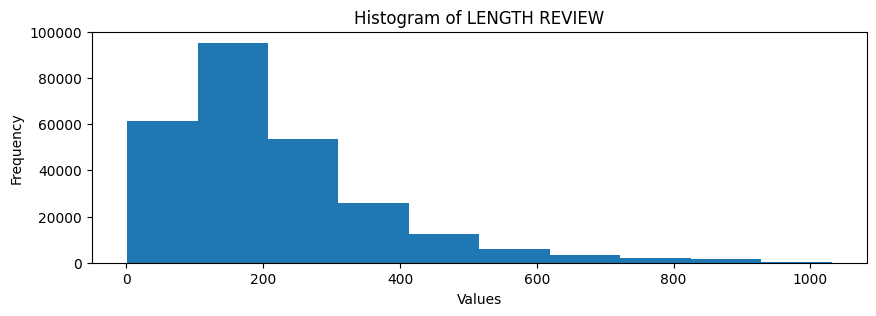

In [19]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(filter_data['length_review'], bins=10)
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of LENGTH REVIEW')

In [20]:
lower = 150
upper = 400
filter_data_v2 = filter_data.filter(lambda example: lower <= example['length_review'] <= upper)

Filter:   0%|          | 0/261613 [00:00<?, ? examples/s]

In [21]:
import spacy
import re

nlp = spacy.load('en_core_web_lg')

In [22]:
def transform(example):
    doc = nlp(example['text'])
    output = []
    for token in doc:
        if token.ent_type_ == 'PERSON':   
            word = '<PERSON>'
        elif token.ent_type_ == 'MONEY':
            word = '<MONEY>'
        else:
            word = token.text
        output.append(word)
    modified_text = ' '.join(output)
    modified_text = re.sub(r'\s+([.,!?])', r'\1', modified_text)
    modified_text = re.sub(r'\s+', ' ', modified_text)
    return {'new_text':modified_text}

In [ ]:
filter_data_v2 = filter_data_v2.map(transform)

Map:   0%|          | 0/126571 [00:00<?, ? examples/s]

In [174]:
filter_data_v2.set_format('pandas')
print(filter_data_v2['labels'].value_counts(normalize=True))
print()
print(filter_data_v2['labels'].value_counts())
filter_data_v2.reset_format()
print()
filter_data_v2.shape

labels
2    0.782662
0    0.139592
1    0.077746
Name: proportion, dtype: float64

labels
2    96078
0    17136
1     9544
Name: count, dtype: int64



(122758, 13)

**ONE IMBALANCE SOLUTION**

In [222]:
output = filter_data_v2.train_test_split(test_size=0.02, seed=seed, stratify_by_column='labels')

In [223]:
split_data = output.pop('test')
split_data = split_data.train_test_split(test_size=0.5, seed=seed)
split_data['validation'] = split_data.pop('train')

In [224]:
useful = output['train'].filter(lambda example: example['labels'] == 2)
funny = output['train'].filter(lambda example: example['labels'] == 1)
cool = output['train'].filter(lambda example: example['labels'] == 0)

sizes = [useful.shape[0], funny.shape[0], cool.shape[0]]
frac = (np.min([x / np.sum(sizes) for x in sizes]))
upper = int(useful.shape[0] * frac)

Filter:   0%|          | 0/120302 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120302 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120302 [00:00<?, ? examples/s]

In [225]:
ids = np.argsort(useful['useful'])[::-1][0:upper]
useful = useful.select(ids)

ids = np.argsort(funny['funny'])[::-1][0:upper]
funny = funny.select(ids)

ids = np.argsort(cool['cool'])[::-1][0:upper]
cool = cool.select(ids)

split_data['train'] = concatenate_datasets([useful, cool, funny]).shuffle(seed=seed)

In [226]:
split_data['train'].set_format('pandas')
print(split_data['train']['labels'].value_counts(normalize=True))
print()
print(split_data['train']['labels'].value_counts())
split_data['train'].reset_format()
print()
split_data['train'].shape

labels
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

labels
0    7320
2    7320
1    7320
Name: count, dtype: int64



(21960, 13)

In [227]:
split_data

DatasetDict({
    test: Dataset({
        features: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'count_review', 'labels', 'length_review', 'new_text'],
        num_rows: 1228
    })
    validation: Dataset({
        features: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'count_review', 'labels', 'length_review', 'new_text'],
        num_rows: 1228
    })
    train: Dataset({
        features: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'count_review', 'labels', 'length_review', 'new_text'],
        num_rows: 21960
    })
})

In [228]:
for split, dataset in split_data.items():
    dataset.to_csv(f"./yelp-data-v2/yelp-classification-{split}.csv")

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]